<a href="https://colab.research.google.com/github/vicotrbb/machine_learning/blob/master/machine_learning/neural_networks/image_style_transfer_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imnage style transfer using transfer learning.

### References

* https://towardsdatascience.com/transfer-an-artistic-image-style-to-any-image-bf71a256ba4
* https://towardsdatascience.com/style-up-your-photos-with-a-touch-of-deep-learning-magic-60a003c676f9
* https://harishnarayanan.org/writing/artistic-style-transfer/

In [104]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import pprint
import imageio
import cv2
import zipfile

In [105]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
content_path = 'drive/My Drive/image_style_transfer/me.jpeg'
style_path = 'drive/My Drive/image_style_transfer/lofi.jpg'

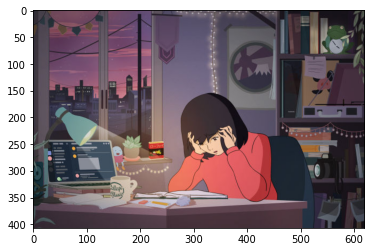

In [ ]:
image = plt.imread(style_path)
plt.imshow(image)

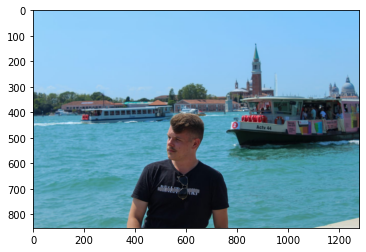

In [ ]:
image = plt.imread(content_path)
plt.imshow(image)

In [ ]:
def normalise_image(image):
  MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
  width = 620
  height = 407
  dim = (width, height)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  image = np.expand_dims(image, axis=0)
  image = image - MEANS
  return image

In [ ]:
def content_cost(gen_image, con_image):
  #input as tensors
  return (tf.reduce_sum(tf.square(gen_image-con_image)))

In [ ]:
def gram_matrix(m):
  #input tensor of shape (n_w*n_h,n_c)
  return tf.matmul(tf.transpose(m),m)

In [ ]:
def single_style_cost(gen_image, st_image):
  gen_image = tf.squeeze(gen_image)
  st_image = tf.squeeze(st_image)
  
  n_w, n_h, n_c = gen_image.get_shape().as_list()
  gen_r = tf.reshape(gen_image, shape=[n_w*n_h,n_c])
  st_r = tf.reshape(st_image, shape=[n_w*n_h,n_c])
  
  gram_gen = gram_matrix(gen_r)
  gram_st = gram_matrix(st_r)
  
  return tf.reduce_sum(tf.square(gram_st - gram_gen))

In [ ]:
def style_cost(model, style_layer):
  cost = 0
  weights = float(1/len(style_layer))
  # iterating through each layer
  for layer in style_layer:
    output = model[layer]
    #activations of this layer
    st_im = sess.run(output)
    
    gen_im = output
    cost+= weights*single_style_cost(gen_im,st_im)
  return cost

In [106]:
def display_image(image, path_to_save):
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image = image + MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imshow(image)
    imageio.imwrite(path_to_save, image)

In [ ]:
def get_model(path):
  with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
get_model('drive/My Drive/image_style_transfer/model.zip')

In [ ]:
class CONFIG:
  IMAGE_WIDTH = 620
  IMAGE_HEIGHT = 407
  COLOR_CHANNELS = 3
  NOISE_RATIO = 0.6
  MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
  VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
  STYLE_IMAGE = style_path
  CONTENT_IMAGE = content_path
  OUTPUT_DIR = 'output/'
    
def load_vgg_model(path):
  """
  Returns a model for the purpose of 'painting' the picture.
  Takes only the convolution layer weights and wrap using the TensorFlow
  Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
  the paper indicates that using AveragePooling yields better results.
  The last few fully connected layers are not used.
  Here is the detailed configuration of the VGG model:
      0 is conv1_1 (3, 3, 3, 64)
      1 is relu
      2 is conv1_2 (3, 3, 64, 64)
      3 is relu    
      4 is maxpool
      5 is conv2_1 (3, 3, 64, 128)
      6 is relu
      7 is conv2_2 (3, 3, 128, 128)
      8 is relu
      9 is maxpool
      10 is conv3_1 (3, 3, 128, 256)
      11 is relu
      12 is conv3_2 (3, 3, 256, 256)
      13 is relu
      14 is conv3_3 (3, 3, 256, 256)
      15 is relu
      16 is conv3_4 (3, 3, 256, 256)
      17 is relu
      18 is maxpool
      19 is conv4_1 (3, 3, 256, 512)
      20 is relu
      21 is conv4_2 (3, 3, 512, 512)
      22 is relu
      23 is conv4_3 (3, 3, 512, 512)
      24 is relu
      25 is conv4_4 (3, 3, 512, 512)
      26 is relu
      27 is maxpool
      28 is conv5_1 (3, 3, 512, 512)
      29 is relu
      30 is conv5_2 (3, 3, 512, 512)
      31 is relu
      32 is conv5_3 (3, 3, 512, 512)
      33 is relu
      34 is conv5_4 (3, 3, 512, 512)
      35 is relu
      36 is maxpool
      37 is fullyconnected (7, 7, 512, 4096)
      38 is relu
      39 is fullyconnected (1, 1, 4096, 4096)
      40 is relu
      41 is fullyconnected (1, 1, 4096, 1000)
      42 is softmax
  """
  
  vgg = scipy.io.loadmat(path)

  vgg_layers = vgg['layers']
  
  def _weights(layer, expected_layer_name):
    """
    Return the weights and bias from the VGG model for a given layer.
    """
    wb = vgg_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = vgg_layers[0][layer][0][0][0][0]
    assert layer_name == expected_layer_name
    return W, b

    return W, b

  def _relu(conv2d_layer):
    """
    Return the RELU function wrapped over a TensorFlow layer. Expects a
    Conv2d layer input.
    """
    return tf.nn.relu(conv2d_layer)

  def _conv2d(prev_layer, layer, layer_name):
    """
    Return the Conv2D layer using the weights, biases from the VGG
    model at 'layer'.
    """
    W, b = _weights(layer, layer_name)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, (b.size)))
    return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

  def _conv2d_relu(prev_layer, layer, layer_name):
    """
    Return the Conv2D + RELU layer using the weights, biases from the VGG
    model at 'layer'.
    """
    return _relu(_conv2d(prev_layer, layer, layer_name))

  def _avgpool(prev_layer):
    """
    Return the AveragePooling layer.
    """
    return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # Constructs the graph model.
  graph = {}
  graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
  graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
  graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
  graph['avgpool1'] = _avgpool(graph['conv1_2'])
  graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
  graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
  graph['avgpool2'] = _avgpool(graph['conv2_2'])
  graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
  graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
  graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
  graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
  graph['avgpool3'] = _avgpool(graph['conv3_4'])
  graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
  graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
  graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
  graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
  graph['avgpool4'] = _avgpool(graph['conv4_4'])
  graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
  graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
  graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
  graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
  graph['avgpool5'] = _avgpool(graph['conv5_4'])
  
  return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
  """
  Generates a noisy image by adding random noise to the content_image
  """
  noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
  input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
  return input_image


def reshape_and_normalize_image(image):
  """
  Reshape and normalize the input image (content or style)
  """
  image = np.reshape(image, ((1,) + image.shape))
  image = image - CONFIG.MEANS
  return image


def save_image(path, image):
  image = image + CONFIG.MEANS
  image = np.clip(image[0], 0, 255).astype('uint8')
  scipy.imsave(path, image)

## The model

In [ ]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

In [ ]:
def model_nn(sess,content_path, style_path, num_iterations = 2000, learning_rate = 2, alpha=10, beta = 1e-12):
  #loading content image
  content = plt.imread(content_path)
  content = normalise_image(content)
  print(content.shape)
  
  #loading style image
  style = plt.imread(style_path)
  style = normalise_image(style)
  print(style.shape)
  
  #defining content layers and style layers
  content_layer = ['conv5_3']
  style_layer = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

  #defining input image to be styled
  input_image = plt.imread(content_path)
  input_image = normalise_image(input_image)

  model = model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

  #computing content cost
  sess.run(model["input"].assign(content))
  out = model[content_layer[0]]
  act_content = sess.run(out)
  act_gen = out
  con_cost = content_cost(act_gen,act_content)

  #computing style cost
  sess.run(model["input"].assign(style))
  sty_cost = style_cost(model,style_layer)
  total_cost = alpha*con_cost + beta*sty_cost

  #defining optimizer
  opt = tf.compat.v1.train.AdamOptimizer(learning_rate)
  train_step = opt.minimize(total_cost)

  sess.run(tf.compat.v1.global_variables_initializer())
  
  sess.run(model['input'].assign(input_image))

  #initialising best_loss, to select minimin loss from all the calculated losses
  best_loss = float("inf")
  best_out = input_image
  for i in range(num_iterations):

    sess.run(train_step)
    generated_image = sess.run(model['input'])
    cst = sess.run(total_cost)

    #updating best loss and best image corresponding to minimum loss encountered yet
    if cst<best_loss:
      best_loss = cst
      best_out = generated_image

    if i%100 == 0:
      t_c, c_c, s_c = sess.run([total_cost, con_cost, sty_cost])
      print("Iteration " + str(i) + " :")
      print("total cost = " + str(t_c))
      print("content cost = " + str(c_c))
      print("style cost = " + str(s_c))

  return best_out

## basic result

In [ ]:
output_img = model_nn(sess=sess, content_path=content_path, style_path=style_path, num_iterations=2000, learning_rate = 2.5, alpha=10, beta = 1e-12)

(1, 407, 620, 3)
(1, 407, 620, 3)
Iteration 0 :
total cost = 2602403800.0
content cost = 3003612.2
style cost = 2.5723677e+21
Iteration 100 :
total cost = 82193740.0
content cost = 2005387.5
style cost = 6.2139863e+19
Iteration 200 :
total cost = 45484004.0
content cost = 1507649.5
style cost = 3.0407509e+19
Iteration 300 :
total cost = 32694120.0
content cost = 1300436.8
style cost = 1.9689753e+19
Iteration 400 :
total cost = 26331352.0
content cost = 1182266.5
style cost = 1.4508686e+19
Iteration 500 :
total cost = 22636220.0
content cost = 1100417.4
style cost = 1.1632047e+19
Iteration 600 :
total cost = 20270554.0
content cost = 1036267.7
style cost = 9.907877e+18
Iteration 700 :
total cost = 18627576.0
content cost = 984199.8
style cost = 8.785578e+18
Iteration 800 :
total cost = 17398058.0
content cost = 943277.5
style cost = 7.965283e+18
Iteration 900 :
total cost = 16431330.0
content cost = 907316.5
style cost = 7.3581644e+18
Iteration 1000 :
total cost = 15619868.0
content cos

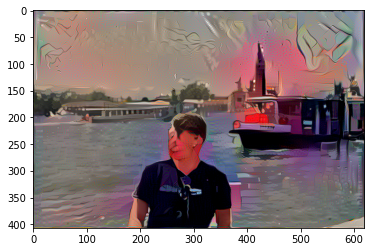

In [ ]:
display_image(output_img, 'drive/My Drive/image_style_transfer/outputs/try-07.jpg')

# Second try


In [2]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [3]:
model = VGG16(weights='imagenet', include_top=True)
layers = dict([(layer.name, layer.output) for layer in model.layers])

553467904/553467096 [==============================] - 2s 0us/step


In [4]:
layers

{'block1_conv1': <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 'block3_pool': <KerasTensor: shap

In [5]:
model.count_params()

138357544

In [76]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
import imageio

In [77]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [78]:
content_path = 'drive/My Drive/image_style_transfer/me.jpeg'
style_path = 'drive/My Drive/image_style_transfer/lofi.jpg'

In [79]:
height = 512
width = 512

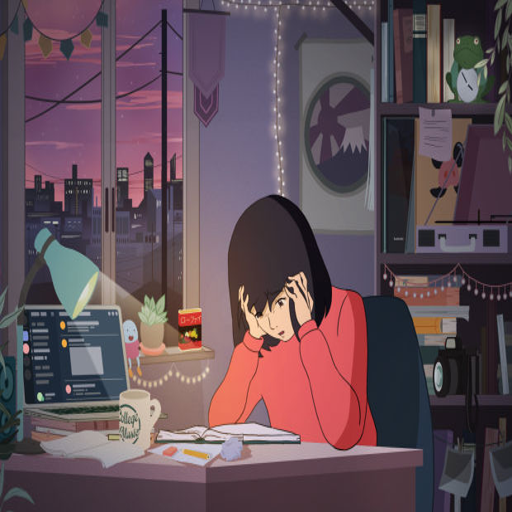

In [80]:
style_image = Image.open(style_path)
style_image = style_image.resize((width, height))
style_image

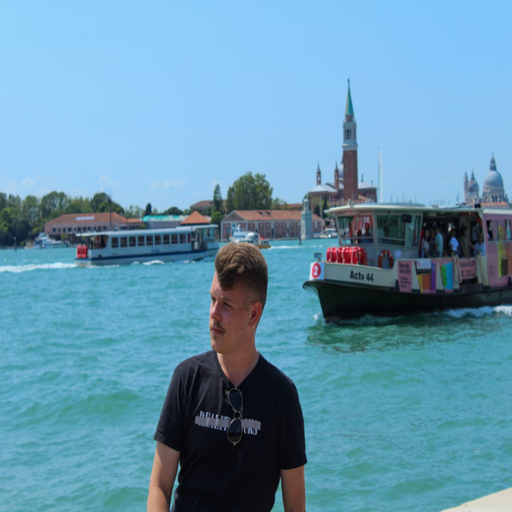

In [81]:
content_image = Image.open(content_path)
content_image = content_image.resize((width, height))
content_image

In [82]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [83]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [84]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [85]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [86]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [87]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [88]:
content_weight = backend.variable(0.025)
style_weight = backend.variable(5.0)
total_variation_weight = backend.variable(1.0)

loss = backend.variable(0.)

In [89]:
def content_loss(content, combination):
  return backend.sum(backend.square(combination - content))

In [90]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [91]:
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram

In [92]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [93]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [94]:
for layer_name in feature_layers:
  layer_features = layers[layer_name]
  style_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_features, combination_features)
  loss += (style_weight / len(feature_layers)) * sl

In [95]:
def total_variation_loss(x):
  a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
  b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))

In [96]:
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [97]:
grads = backend.gradients(loss, combination_image)

In [98]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

In [99]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [100]:
class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    loss_value, grad_values = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

In [109]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 28675918000.0
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 14225776000.0
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 11028263000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 9663833000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 8981662000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 8574134000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 8300955000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 8101609500.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 7947858400.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 7820151300.0
Iteration 9 completed in 6s


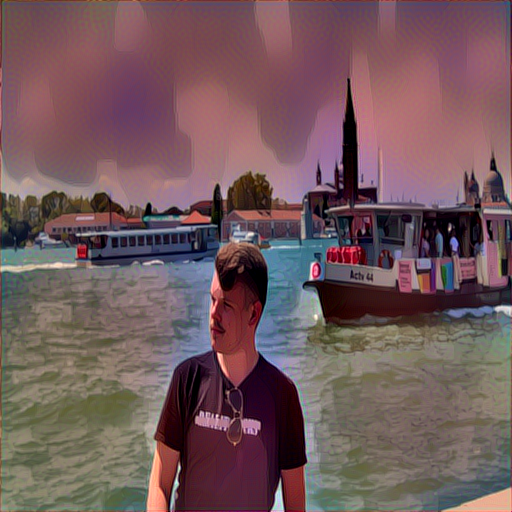

In [110]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [111]:
imageio.imwrite('drive/My Drive/image_style_transfer/outputs/try-08-second-try.jpg', x)